<a href="https://www.kaggle.com/code/davidyaez/feature-engineering-and-nlp-on-e-commerce-reviews?scriptVersionId=120525884" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!python -m spacy download en # NLP


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 51.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv


Read in csv as pandas dataframe:

In [2]:
df = pd.read_csv("/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv")

# Data Dictionary
[Taken from Kaggle](https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews)

* Clothing ID: Integer Categorical variable that refers to the specific piece being reviewed.
* Age: Positive Integer variable of the reviewers age.
* Title: String variable for the title of the review.
* Review Text: String variable for the review body.
* Rating: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.
* Recommended IND: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.
* Positive Feedback Count: Positive Integer documenting the number of other customers who found this review positive.
* Division Name: Categorical name of the product high level division.
* Department Name: Categorical name of the product department name.
* Class Name: Categorical name of the product class name.

Rename columns to be pythonic:

In [3]:
renamed_columns = [column.lower().replace(" ", "_") for column in df.columns]
df.columns = renamed_columns

Investigate which columns can be dropped:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   unnamed:_0               23486 non-null  int64 
 1   clothing_id              23486 non-null  int64 
 2   age                      23486 non-null  int64 
 3   title                    19676 non-null  object
 4   review_text              22641 non-null  object
 5   rating                   23486 non-null  int64 
 6   recommended_ind          23486 non-null  int64 
 7   positive_feedback_count  23486 non-null  int64 
 8   division_name            23472 non-null  object
 9   department_name          23472 non-null  object
 10  class_name               23472 non-null  object
dtypes: int64(6), object(5)
memory usage: 2.0+ MB


```unnamed:_0``` doesn't seem like a feature. Drop it:

In [5]:
print("Value Counts:\n", df["unnamed:_0"].value_counts())
print("--------------")
print("Unique Values:\n", df["unnamed:_0"].nunique())

df = df.drop(columns="unnamed:_0")

Value Counts:
 0        1
15664    1
15662    1
15661    1
15660    1
        ..
7827     1
7826     1
7825     1
7824     1
23485    1
Name: unnamed:_0, Length: 23486, dtype: int64
--------------
Unique Values:
 23486


```title``` and ```review_text``` can be concatenated since they are part of the same review:

In [6]:
concat_reviews = []

for title, review in zip(df["title"], df["review_text"]):
    if not pd.isnull(title) and pd.isnull(review):
        concat_review = title
    elif pd.isnull(title) and not pd.isnull(review):
        concat_review = review
    elif not pd.isnull(title) and not pd.isnull(review):
        concat_review = title + " " + review
    concat_reviews.append(concat_review)
    
df = df.drop(columns=["title", "review_text"])
df["concat_reviews"] = concat_reviews

```clothing_id``` refers to the individual piece being sold, making it suspect for machine learning:

In [7]:
print("Value Counts:\n", df["clothing_id"].value_counts())
print("--------------")
print("Unique Values:\n", df["clothing_id"].nunique())

df = df.drop(columns=["clothing_id"])

Value Counts:
 1078    1024
862      806
1094     756
1081     582
872      545
        ... 
776        1
668        1
633        1
734        1
522        1
Name: clothing_id, Length: 1206, dtype: int64
--------------
Unique Values:
 1206


Check missing values. With .06% of rows with missing values, these can be simply dropped:

In [8]:
print("Percentage of missing values:")
print("-----------------------------")
print(df.isnull().mean().round(4).mul(100).sort_values(ascending=False))

df = df.dropna(axis=0)

Percentage of missing values:
-----------------------------
division_name              0.06
department_name            0.06
class_name                 0.06
age                        0.00
rating                     0.00
recommended_ind            0.00
positive_feedback_count    0.00
concat_reviews             0.00
dtype: float64


Check for and drop duplicated entries:

In [9]:
df.duplicated().sum()
df = df.drop_duplicates()

With irrelevant columns dropped, let's look at the distribution numerical data:

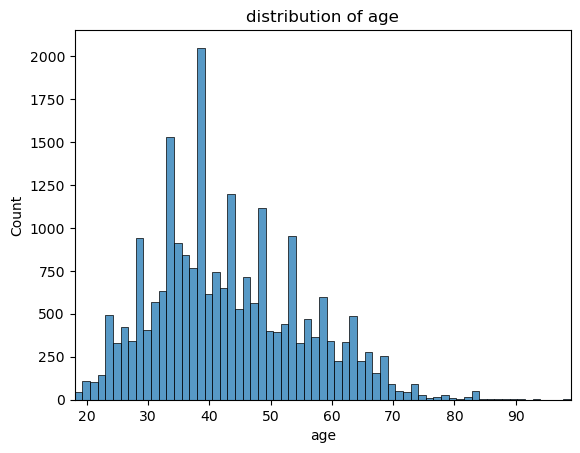

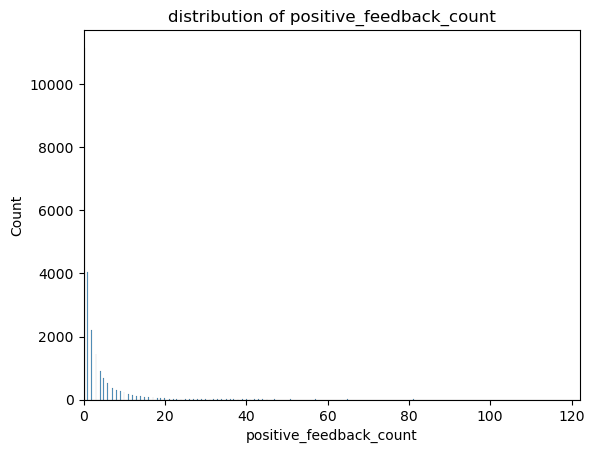

In [10]:
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization


columns = ["age", "positive_feedback_count"]

for column in columns:
    sns.histplot(x=df[column])
    plt.title(f"distribution of {column}")
    plt.xlim(df[column].min(), df[column].max())
    plt.show()


There seems to be some skewness in the distributions (although reccomended_ind is binary/categorical, which does not apply):

In [11]:
from scipy.stats import skew

columns = ["age", "rating", "positive_feedback_count"]

for column in columns:
    skewness = skew(df[column])
    print(f"{column}: {skewness}")

age: 0.5254714457914279
rating: -1.312480250916517
positive_feedback_count: 6.4708741835762


```age``` and ```positive_feedback_count``` are right-skewed. A logorithmic transformation can help make these distrubtions more normal. However, log cannot occur with 0 values, so, we can alter 0 values to make them non-zero:

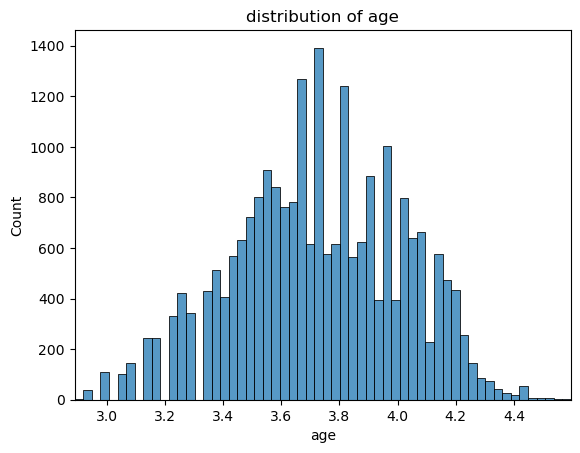

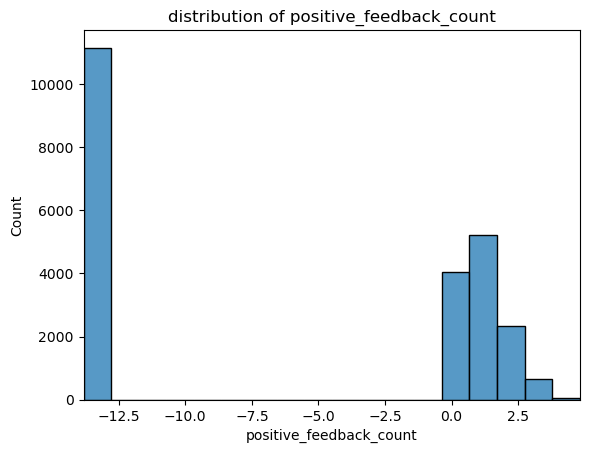

In [12]:
df["positive_feedback_count"] = df["positive_feedback_count"] + .000001

columns = ["age", "positive_feedback_count"]

for column in columns:
    df[column] = np.log(df[column])
    
for column in columns:
    sns.histplot(x=df[column])
    plt.title(f"distribution of {column}")
    plt.xlim(df[column].min(), df[column].max())
    plt.show()
    

Encode categorical data:

In [13]:
columns = ["division_name", "department_name", "class_name"]

for column in columns:
    print(f"unique values in: {column}: {df[column].value_counts()}")

unique values in: division_name: General           13849
General Petite     8120
Initmates          1501
Name: division_name, dtype: int64
unique values in: department_name: Tops        10468
Dresses      6319
Bottoms      3798
Intimate     1734
Jackets      1032
Trend         119
Name: department_name, dtype: int64
unique values in: class_name: Dresses           6319
Knits             4843
Blouses           3097
Sweaters          1428
Pants             1388
Jeans             1146
Fine gauge        1100
Skirts             945
Jackets            704
Lounge             691
Swim               349
Outerwear          328
Shorts             317
Sleep              228
Legwear            165
Intimates          154
Layering           146
Trend              119
Casual bottoms       2
Chemises             1
Name: class_name, dtype: int64


Since there are not too many categories in ```department_name``` and ```division_name```, one hot encoding can work. We'll come back to ```class_name``` later:

In [14]:
ohe_department_name = pd.get_dummies(df["department_name"])
ohe_division_name = pd.get_dummies(df["division_name"])

df = df.join(ohe_department_name).join(ohe_division_name)
df = df.drop(columns=["department_name", "division_name"])

```class_name``` has too many unique values to one-hot encode. Instead, let's use binary encoding to reduce dimensionality:

In [15]:
from category_encoders import BinaryEncoder
 
    
df = BinaryEncoder(cols = ["class_name"], drop_invariant = True).fit_transform(df)

Standardize numeric data:

In [16]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()

columns = ["age", "positive_feedback_count"]

for column in columns:
    reshaped_column = np.array(df[column]).reshape(-1, 1)
    df[column] = scaler.fit_transform(reshaped_column)

The dataframe is ready for machine learning, save ```concat_reviews```, which needs special preprocessing for natural language processing/sentiment analysis.

# Preprocessing for NLP

In [17]:
from bs4 import BeautifulSoup


def remove_html(text):
    """Removes html tags from reviews."""
    soup = BeautifulSoup(text, "lxml")
    stripped_text = soup.get_text()
    return stripped_text

In [18]:
import string


def remove_punctuation(text):
    """Removes punctuation from reviews."""
    no_punct_text = "".join([char for char in text if char not in string.punctuation])
    return no_punct_text

In [19]:
import nltk
from nltk.tokenize import RegexpTokenizer


# creates an array of tokens from each word in the review
tokenizer = RegexpTokenizer(r"\w+")

In [20]:
nltk.download('stopwords')
from nltk.corpus import stopwords


def remove_stopwords(text):
    """Removes stopwords from an array of tokens."""
    words = [word for word in text if word not in stopwords.words("english")]
    return words

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
import spacy


lemmatizer = spacy.load('en_core_web_sm', disable = ['parser','ner'])

def lemmatize_text(text):
    """Lemmatizes, or gets the stems of an array of tokens."""
    text = " ".join(text)
    text = lemmatizer(text)
    lemmatized_text = (" ".join([token.lemma_ for token in text]))
    return lemmatized_text

In [22]:
def preprocess_text(text):
    """Returns preprocessed text for NLP."""
    text = text.apply(lambda review: remove_html(review))
    text = text.apply(lambda review: remove_punctuation(review))
    text = text.apply(lambda review: tokenizer.tokenize(review.lower()))
    text = text.apply(lambda review: remove_stopwords(review))
    text = text.apply(lambda review: lemmatize_text(review))
    return text

df["preprocessed_reviews"] = preprocess_text(df["concat_reviews"])

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


Drop ```concat_reviews```:

In [23]:
df = df.drop(columns="concat_reviews")

Perform sentiment analysis on the reviews:

In [24]:
from textblob import TextBlob 
from textblob.en import subjectivity



def get_sentiment(review):
    """Returns a sentiment category and a strength of sentiment from -1 to 1."""
    sentiment_analysis = TextBlob(review)
    sentiment_polarity = sentiment_analysis.sentiment.polarity, 
    sentiment_subjectivity = sentiment_analysis.sentiment.subjectivity
    return sentiment_polarity, sentiment_subjectivity

df["polarity"] = df["preprocessed_reviews"].apply(lambda x: get_sentiment(x)[0][0])

Examine distribution of new ```polarity``` column, which seems normally distributed:

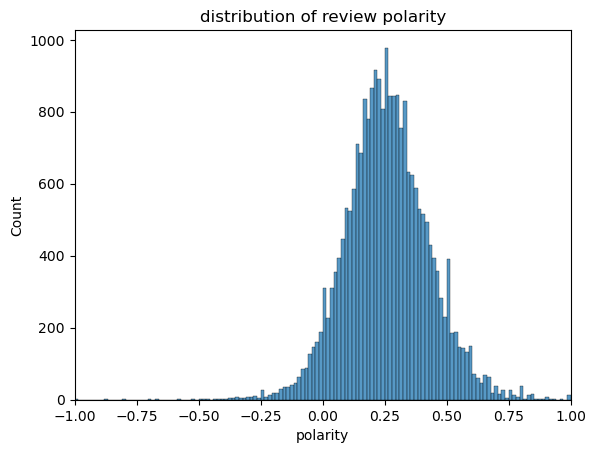

In [25]:
sns.histplot(df["polarity"])
plt.title(f"distribution of review polarity")
plt.xlim(df["polarity"].min(), df["polarity"].max())
plt.show()

# Machine Learning
The data is ready for machine learning. First, seperate into feature matrix and target vector:

In [26]:
X, y = df.drop(columns=["rating", "preprocessed_reviews"]), df["rating"]

Make training and testing splits:

In [27]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Import and initialise XGBoost model:

In [28]:
import xgboost as xgb


xgb = xgb.XGBRegressor()

Fit model to training data:

In [29]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

Get accuracy scores for all folds of k-fold cross-validation:

In [30]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error


kfold = KFold(n_splits=10)
results = cross_val_score(xgb, X_train, y_train, cv=kfold)
y_test_pred = xgb.predict(X_test)
mse = mean_squared_error(y_test_pred, y_test)

for i, result in enumerate(results):
    print(f"Fold :{i} score: {result}")
print("average score:", np.mean(results))

Fold :0 score: 0.6288159495621515
Fold :1 score: 0.602810615599511
Fold :2 score: 0.6411757401658545
Fold :3 score: 0.5972976082235183
Fold :4 score: 0.6463353812361899
Fold :5 score: 0.6586472797087484
Fold :6 score: 0.6092106361567406
Fold :7 score: 0.5948755459825665
Fold :8 score: 0.6162806410822752
Fold :9 score: 0.633348219601206
average score: 0.6228797617318762


This is a very low accuracy score. Let's investigate the importance of the features to find out why:

<BarContainer object of 18 artists>

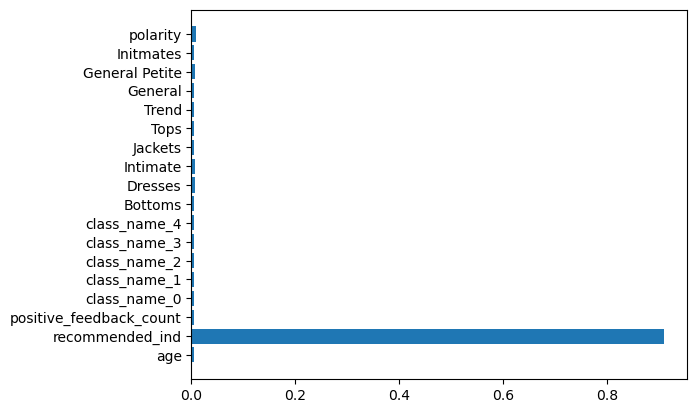

In [31]:
plt.barh(X.columns, xgb.feature_importances_)

It's clear that ```recommended_ind``` is the only real feature with predictive power on ```ratings```. Let's re-run the XGBoost model on only that feature to see if it improves the performance:

In [32]:
X = df["recommended_ind"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

xgb.fit(X_train, y_train)

kfold = KFold(n_splits=10)
results = cross_val_score(xgb, X_train, y_train, cv=kfold)
y_test_pred = xgb.predict(X_test)
mse = mean_squared_error(y_test_pred, y_test)

for i, result in enumerate(results):
    print(f"Fold :{i} score: {result}")
print("average score:", np.mean(results))

Fold :0 score: 0.6296156821653088
Fold :1 score: 0.6035603326900643
Fold :2 score: 0.6430557806715678
Fold :3 score: 0.5970216959354997
Fold :4 score: 0.6325560845869548
Fold :5 score: 0.6700802661111329
Fold :6 score: 0.6296728359055417
Fold :7 score: 0.6022557685922748
Fold :8 score: 0.6181716212542726
Fold :9 score: 0.6393303001826713
average score: 0.6265320368095288


No significant increase in performance. At this point, a different target feature related to a business question may be focused on, but, for now, ```ratings``` doesn't seem like a reliable feature to predict based on this data.